## Change Log
- Updated distance function within custom loss to use all features (instead of only using the distance of the predicted one)
- ToDo: Implement function to load input file with config parameters
- ToDo: Create output file with relevant experiment data
- cluster noise (-1 values) is no longer considered as a cluster in cluster_means

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

## 0. Configuration Parameters
Customizing constants for the run(s).

In [2]:
# config
np.random.seed(23452346)

# Clustering DBSCAN hyperparameters
eps=3
min_samples=5

# TabNet hyperparameters
regr_param = {"optimizer_fn" : torch.optim.Adam,
              "optimizer_params" : dict(lr=2e-2),
              "scheduler_params" : {"step_size": 2, "gamma": 0.9},
              "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
              "mask_type" : 'entmax',

}

model_param = {"max_epochs" : 300,
               "patience" : 50}

# RQ2 parameters
mv_percent = [0, 0.15, 0.10]   # percentages of missing values created in the feature columns
pred_features = 1              # percentage of features used to predict missing values (features will be randomly chosen)
runs = 1                       # number of prediction runs performed with the randomly chosen features

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [3]:
from sklearn.datasets import make_blobs

features_arr, clusters_arr = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

<IPython.core.display.Javascript object>


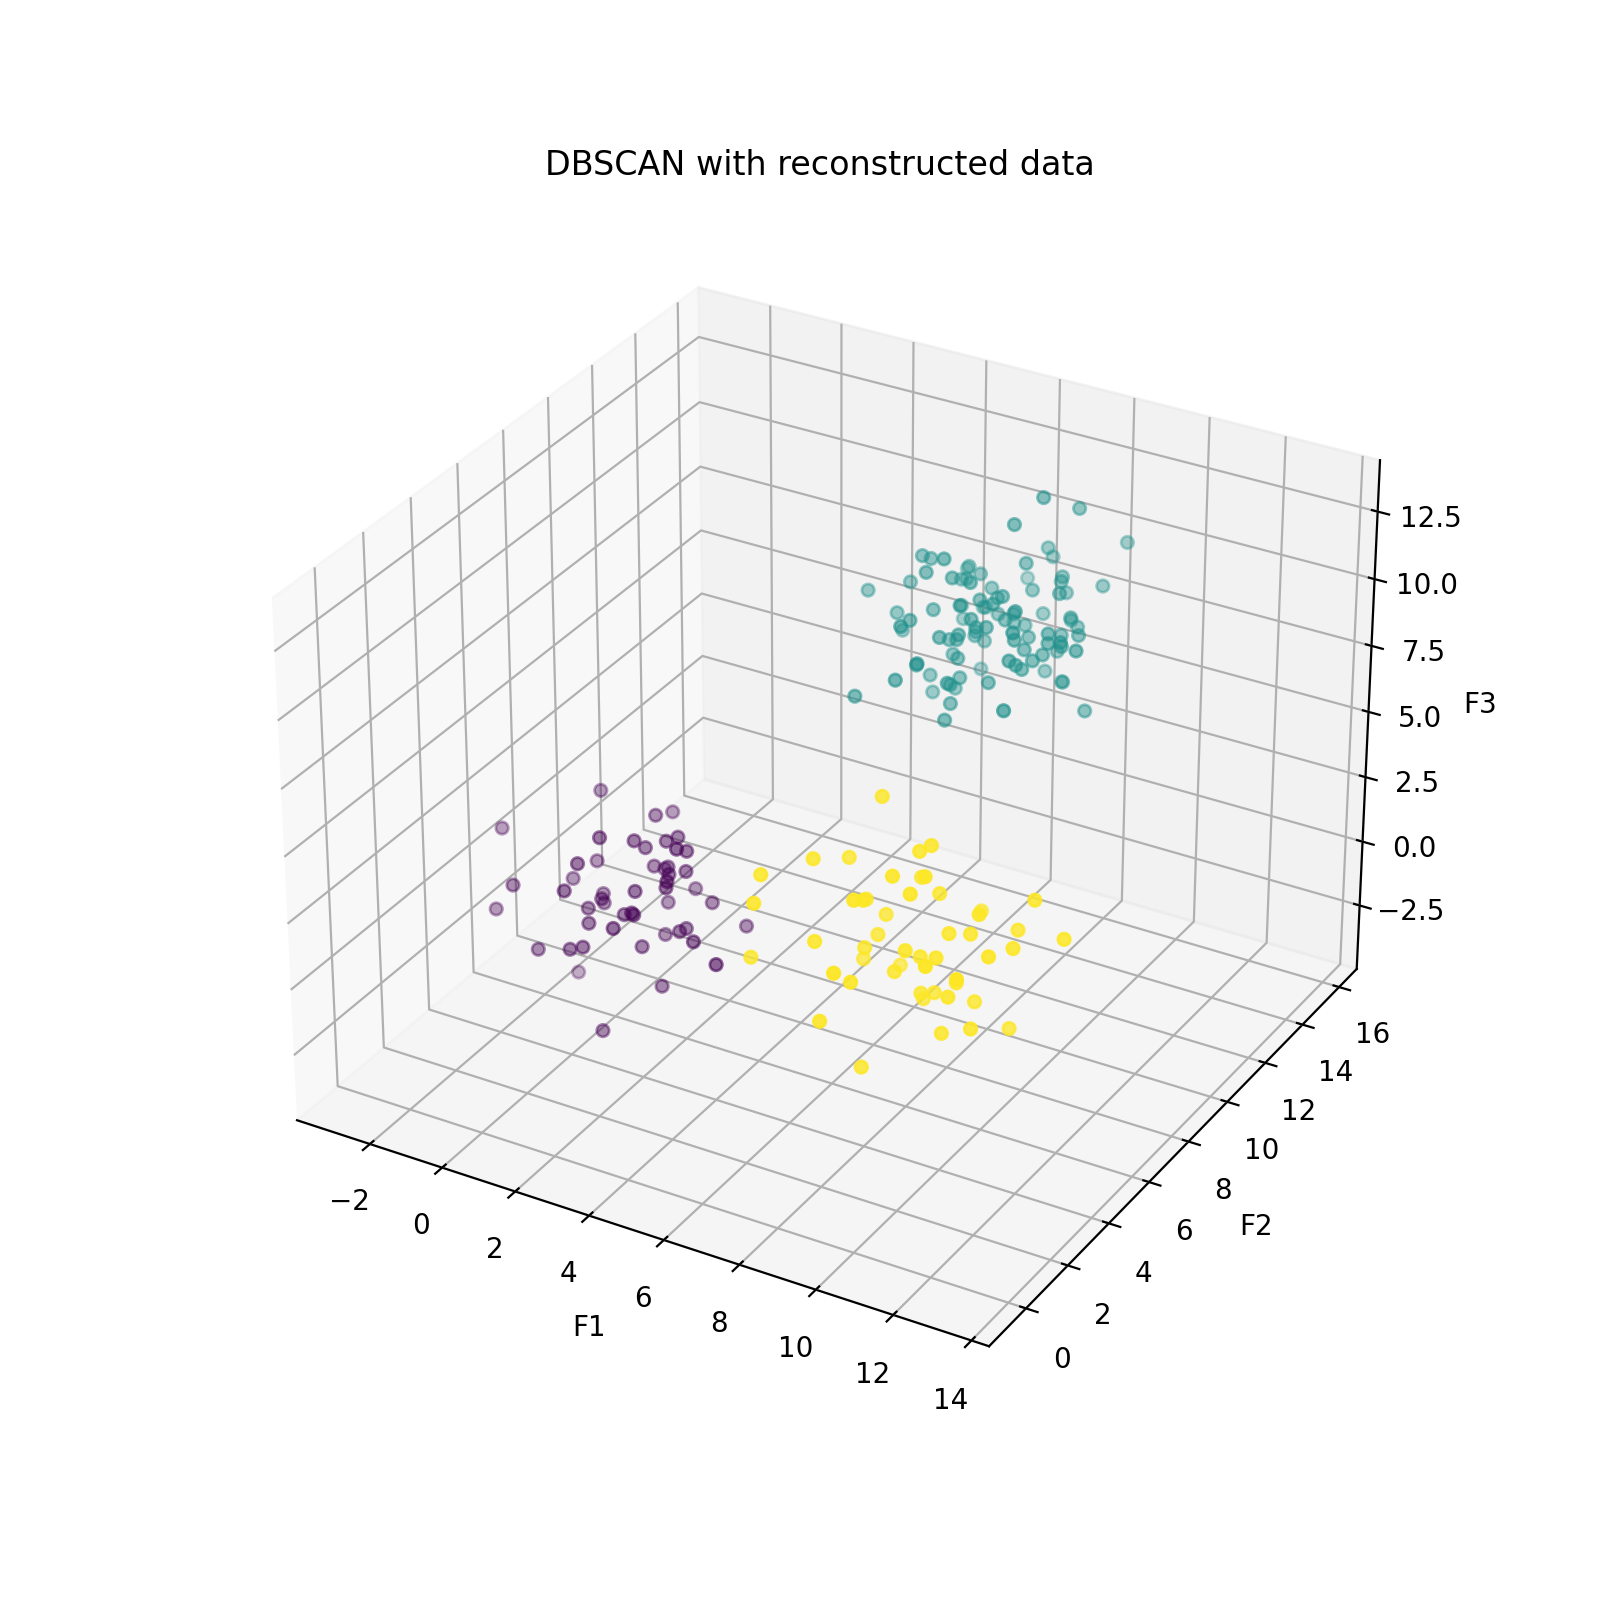

In [4]:
# plot dataset
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [5]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
clusters = pd.DataFrame(clusters_arr, columns=["C"])

# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

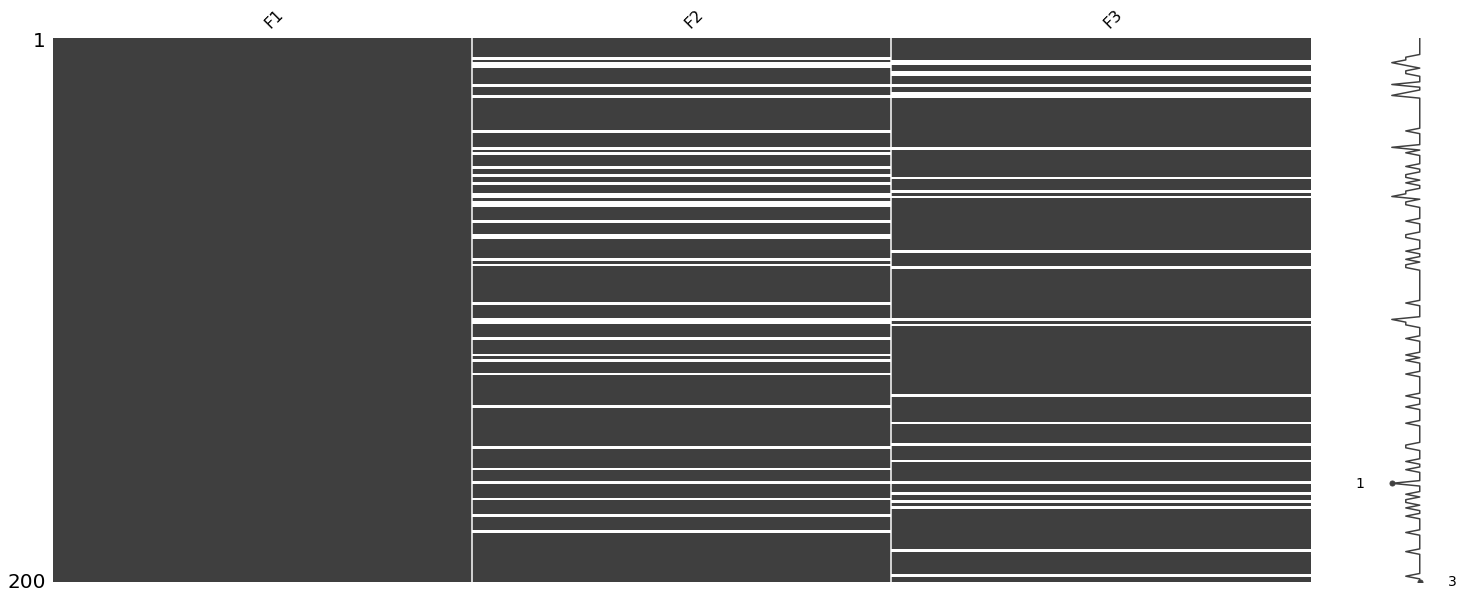

In [6]:
import missingno as msno
%matplotlib inline
# plot missing values
msno.matrix(features_mv)
plt.show()

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [7]:
dbscan_orig = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


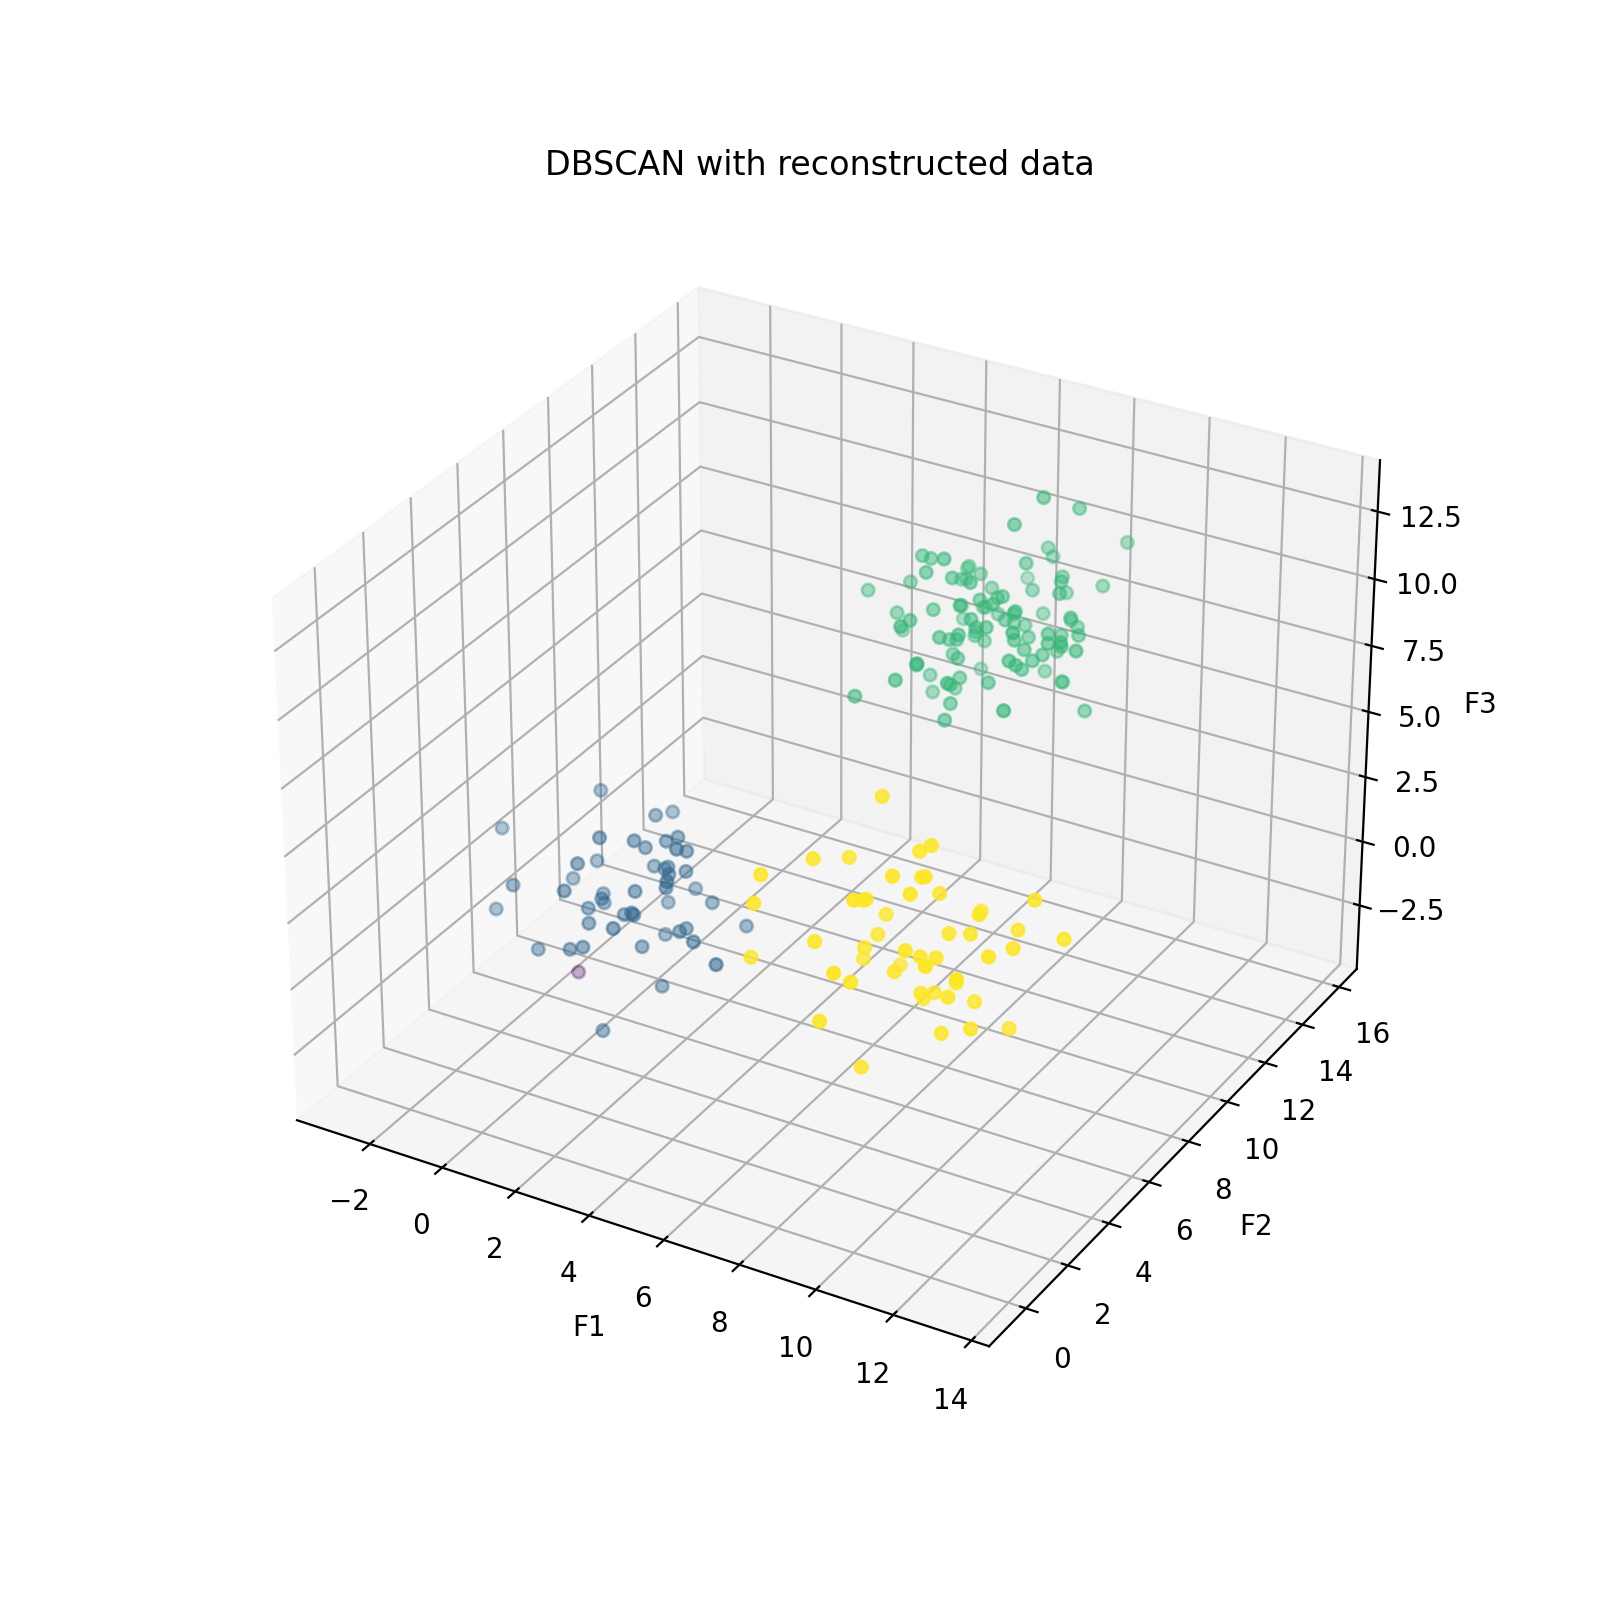

In [8]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

In [9]:
# get cluster means
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


**custom-loss**\
The loss function for the model fitting shall be customized, depending on the goal to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [10]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        custom_loss = cml #+ rmse
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match coods columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # coordinates incl. prediction
        coods = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((coods - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(abs(min_dist))
        

Fill missing values (here with TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [11]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
models = []
features_reconstr = []
costs = {}

for run in range(runs):
    costs[run] = []
    for feature in features_to_predict:
        print(f"Run {run+1}, predicting {feature}")
        features_reconstr.append(features_mv.copy())

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil(pred_features * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as -1
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(-1)
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

        # create & train model
        model = TabNetRegressor(**regr_param)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            **model_param,
            cluster_means=cluster_means,
            target_feature=feature,
            x_val=x_val,
            y_val=y_val,
        )
        
        # add costs to dict
        costs[run].append(model.best_cost)
        
        # add model to list
        models.append(model)

        # fill missing values with model predictions
        features_reconstr[run].loc[features_reconstr[run][feature].isna(),feature] = [x[0] for x in models[len(models)-1].predict(test_data)]

Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
epoch 0  | loss: 35.55313| val_0_custom_loss: 6340.39481|  0:00:00s
epoch 1  | loss: 23.38431| val_0_custom_loss: 3533.31524|  0:00:00s
epoch 2  | loss: 13.08827| val_0_custom_loss: 2939.35112|  0:00:00s
epoch 3  | loss: 8.36463 | val_0_custom_loss: 3417.9909|  0:00:00s
epoch 4  | loss: 5.89736 | val_0_custom_loss: 3228.3988|  0:00:00s
epoch 5  | loss: 3.78174 | val_0_custom_loss: 2810.26676|  0:00:00s
epoch 6  | loss: 2.53042 | val_0_custom_loss: 2297.42802|  0:00:00s
epoch 7  | loss: 2.08637 | val_0_custom_loss: 1998.76344|  0:00:00s
epoch 8  | loss: 2.07247 | val_0_custom_loss: 1768.72784|  0:00:00s
epoch 9  | loss: 1.97093 | val_0_custom_loss: 1649.57987|  0:00:00s
epoch 10 | loss: 1.83613 | val_0_custom_loss: 1337.30815|  0:00:00s
epoch 11 | loss: 1.69453 | val_0_custom_loss: 909.73514|  0:00:00s
epoch 12 | loss: 1.55486 | val_0_custom_loss: 649.1172|  0:00:00s
epoch 13 | loss: 1.46818 | val_0_custom

epoch 25 | loss: 1.11103 | val_0_custom_loss: 983.18349|  0:00:01s
epoch 26 | loss: 1.07177 | val_0_custom_loss: 960.60604|  0:00:01s
epoch 27 | loss: 1.05704 | val_0_custom_loss: 939.30146|  0:00:01s
epoch 28 | loss: 1.03636 | val_0_custom_loss: 921.86706|  0:00:01s
epoch 29 | loss: 1.01975 | val_0_custom_loss: 914.91151|  0:00:01s
epoch 30 | loss: 1.00298 | val_0_custom_loss: 910.57854|  0:00:01s
epoch 31 | loss: 0.98062 | val_0_custom_loss: 909.65579|  0:00:01s
epoch 32 | loss: 0.96893 | val_0_custom_loss: 905.98025|  0:00:01s
epoch 33 | loss: 0.95382 | val_0_custom_loss: 900.42793|  0:00:01s
epoch 34 | loss: 0.93201 | val_0_custom_loss: 897.32929|  0:00:01s
epoch 35 | loss: 0.91013 | val_0_custom_loss: 896.99348|  0:00:01s
epoch 36 | loss: 0.89189 | val_0_custom_loss: 897.25902|  0:00:01s
epoch 37 | loss: 0.8726  | val_0_custom_loss: 898.20688|  0:00:01s
epoch 38 | loss: 0.85028 | val_0_custom_loss: 899.31568|  0:00:01s
epoch 39 | loss: 0.83282 | val_0_custom_loss: 900.75561|  0:00

## 3. Complete Dataset
Costs for each run

In [12]:
costs

{0: [492.65993892205256, 745.2934312567094]}

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [13]:
cost_totals = [sum([x**2 for x in c]) for _, c in costs.items()]
best_model = cost_totals.index(min(cost_totals))
features_final = features_reconstr[best_model]
print(f"Best model: run {best_model} with custom losses {costs[best_model]} for features {list(features_to_predict)}")

Best model: run 0 with custom losses [492.65993892205256, 745.2934312567094] for features ['F2', 'F3']


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


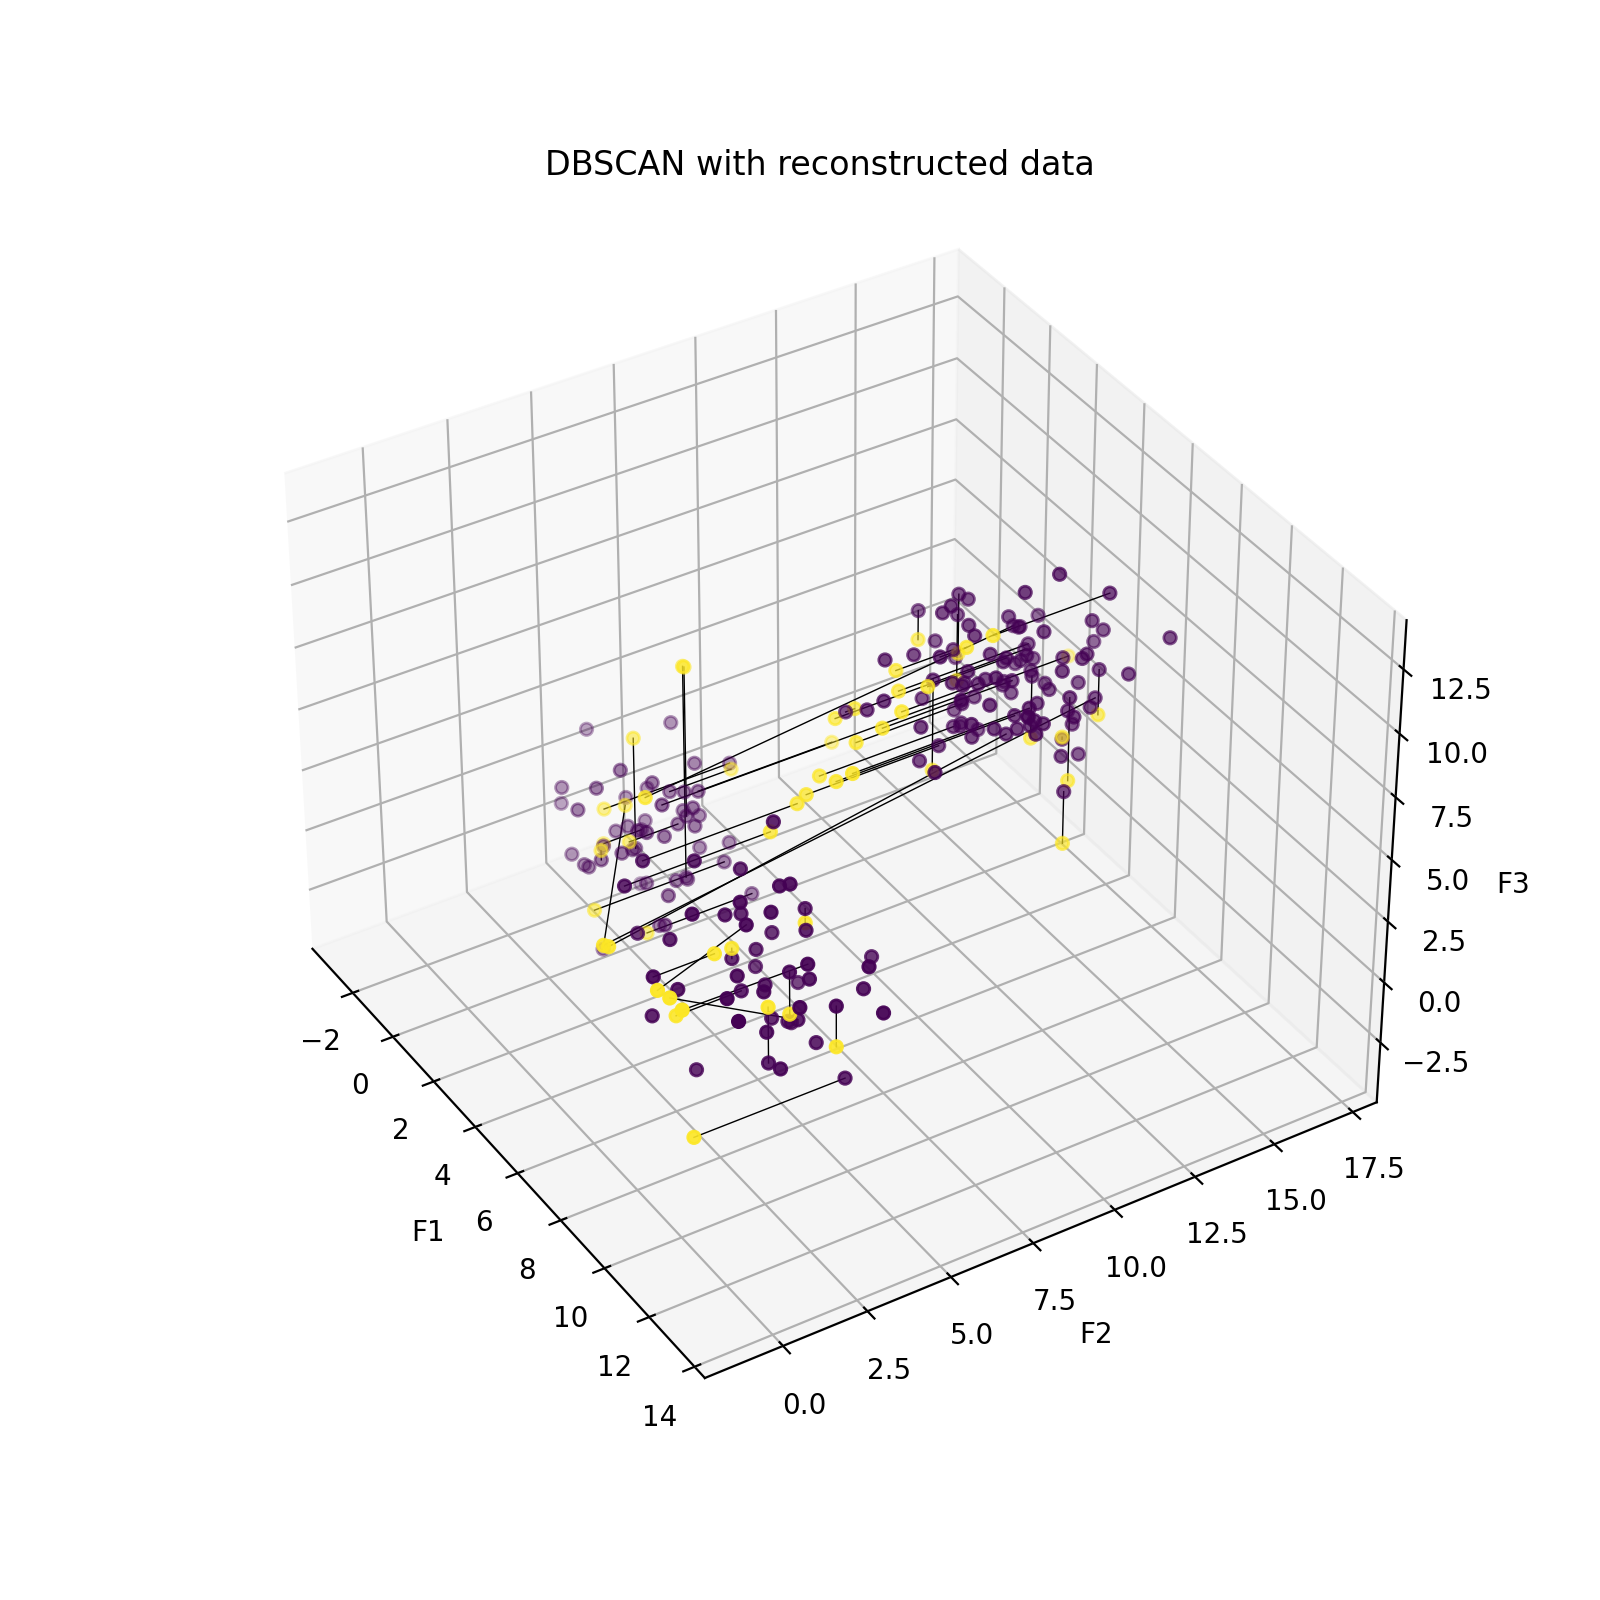

<function matplotlib.pyplot.show(block=None)>

In [14]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_final[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_final[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show

## 4. Clustering

In [15]:
# apply clustering
dbscan_reconstr = DBSCAN(eps=eps, min_samples=min_samples).fit(features_final)
clusters_reconstr = dbscan_reconstr.labels_

<IPython.core.display.Javascript object>


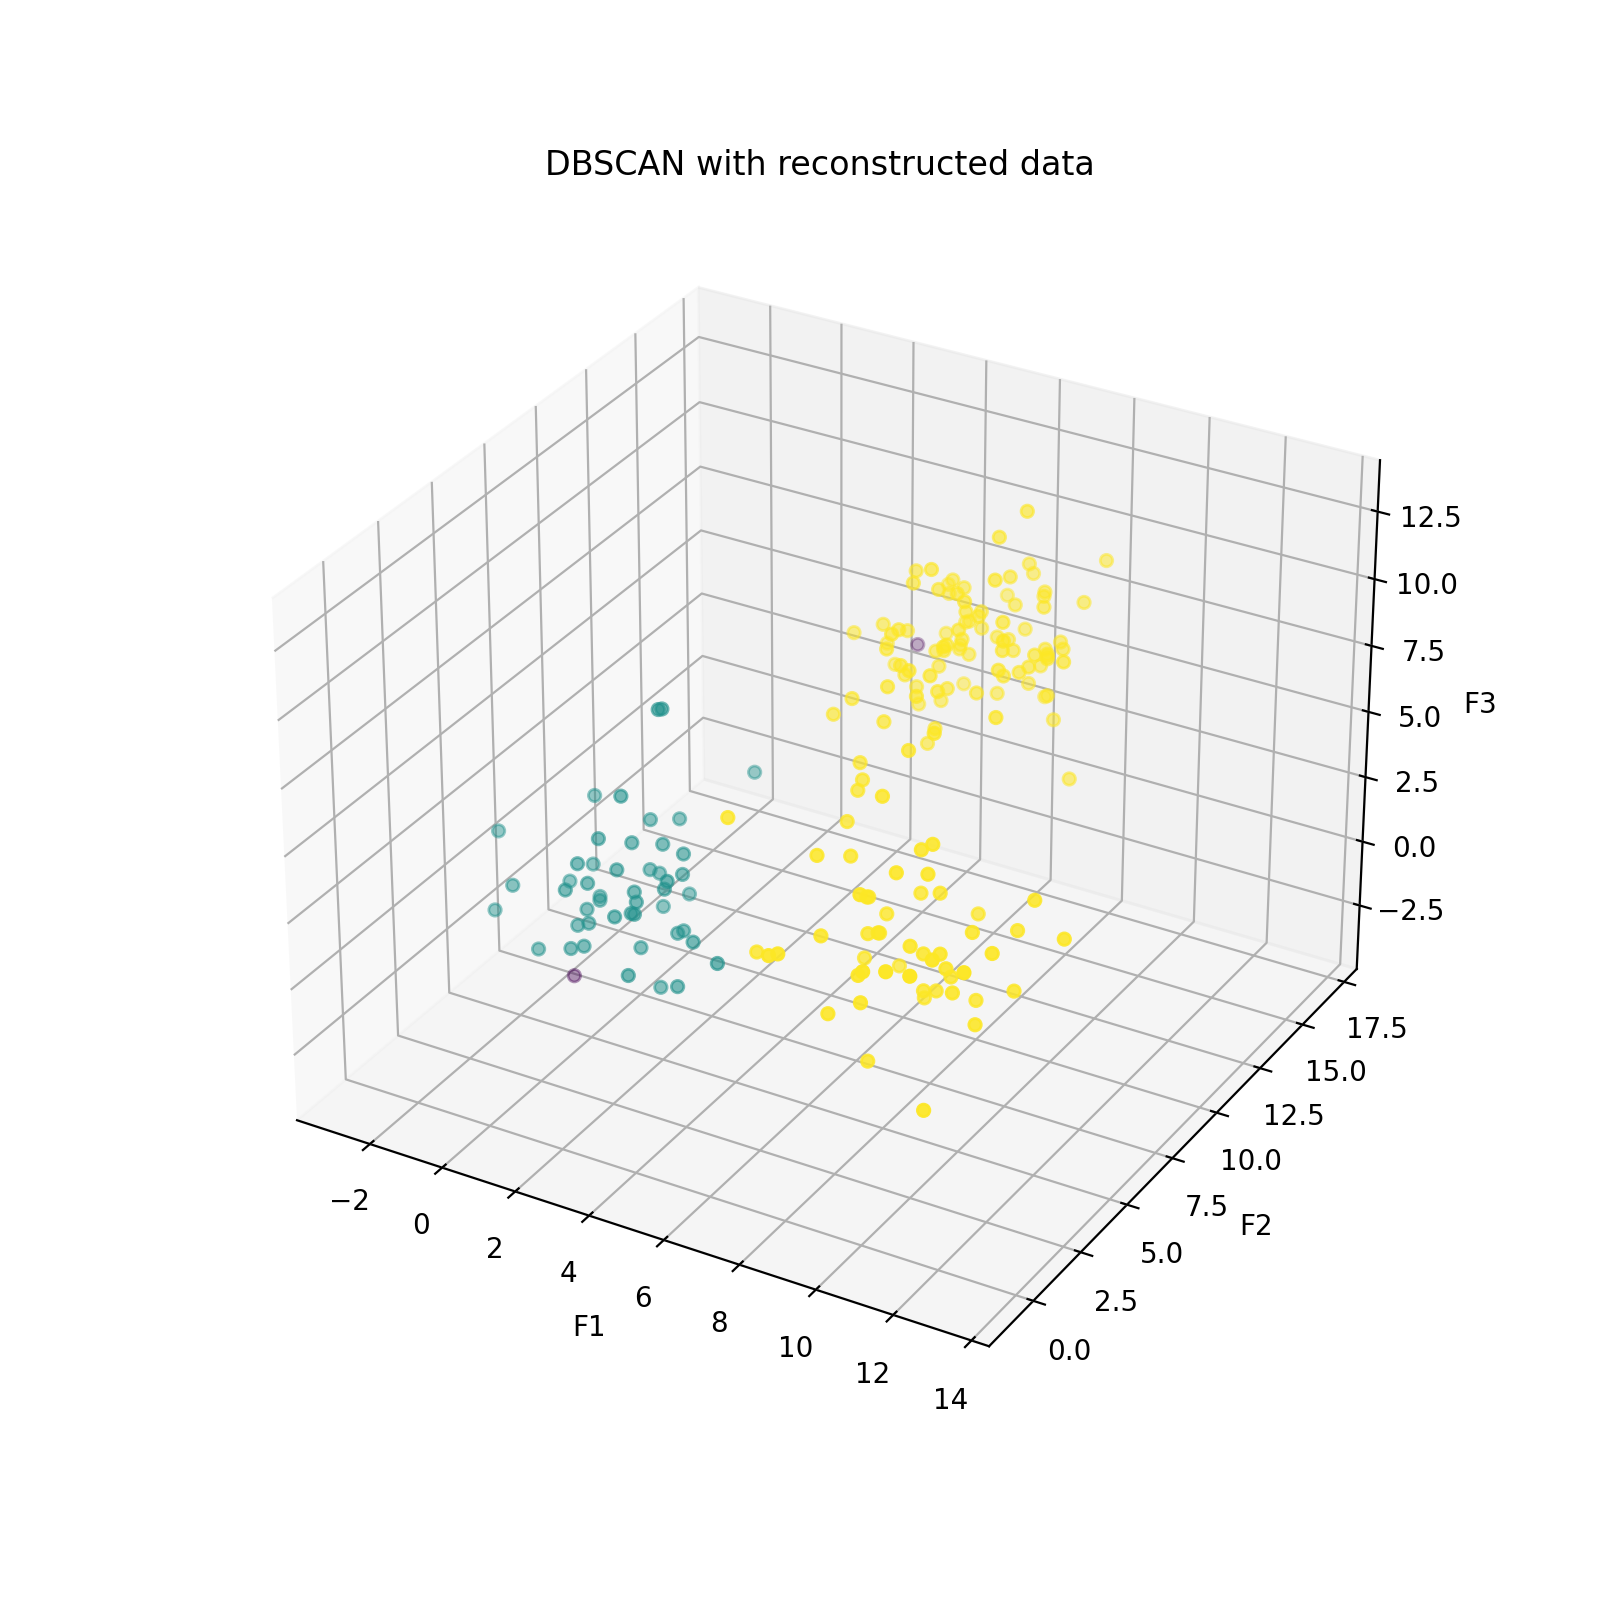

In [16]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_final.iloc[:, 0], features_final.iloc[:, 1], features_final.iloc[:, 2], c=clusters_reconstr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()

## 5. Cluster Performance
### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots

<IPython.core.display.Javascript object>


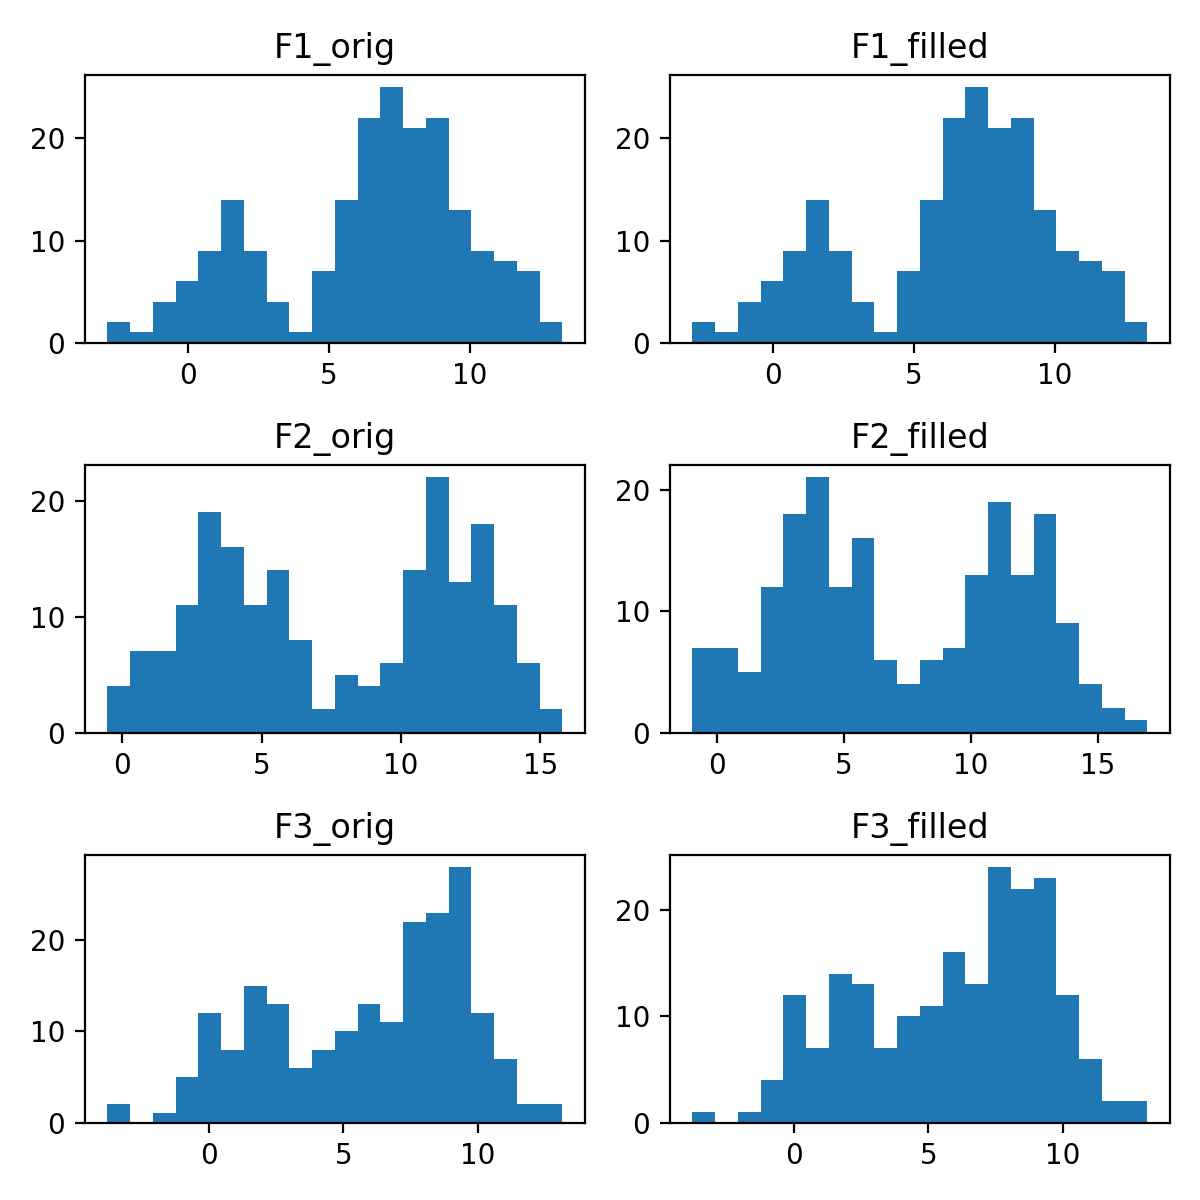

In [17]:
# plot distributions
bins = 20
n_feat = len(features_final.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_final.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_final[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()

#### 5.1.2 KL Divergence
Based on implementation from https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula

In [18]:
# calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr

# calculate probabilities
def probability_dist(x, y, bins):
    # histogram
    hist_xy = np.histogram2d(x, y, bins=bins)[0]

    # compute marginals
    hist_xy = hist_xy + sys.float_info.min # prevent division with 0
    hist_xy = hist_xy / np.sum(hist_xy)
    hist_x = np.sum(hist_xy, axis=1)
    hist_y = np.sum(hist_xy, axis=0)
    return(hist_x, hist_y)

# calculate kl divergence
for n, feature in enumerate(features_final):
    dist1, dist2 = probability_dist(features[feature], features_final[feature], bins)
    print(f"KL divergence {feature}_orig to {feature}_filled: {sum(rel_entr(dist1, dist2))}")
    print(f"KL divergence {feature}_filled to {feature}_orig: {sum(rel_entr(dist2, dist1))}")
    print("")
    

KL divergence F1_orig to F1_filled: 0.0
KL divergence F1_filled to F1_orig: 0.0

KL divergence F2_orig to F2_filled: 0.10392941802951942
KL divergence F2_filled to F2_orig: 0.09475935834170483

KL divergence F3_orig to F3_filled: 0.010500893065482813
KL divergence F3_filled to F3_orig: 0.01013793638208878



### 5.2 Cluster Performance
#### 5.3 Noise

In [19]:
print(f"DBSCAN noise orig_data: {sum(clusters_orig == -1)}")
print(f"DBSCAN noise reconstr_data:{sum(clusters_reconstr == -1)}")

DBSCAN noise orig_data: 1
DBSCAN noise reconstr_data:2


#### 5.4 Silhouette Score

In [20]:
from sklearn.metrics import silhouette_score

print(f"Silhouette Score orig_data: {silhouette_score(features, np.ravel(clusters))}")
print(f"Silhouette Score filled_data: {silhouette_score(features_final, clusters_reconstr)}")

Silhouette Score orig_data: 0.6849069820802122
Silhouette Score filled_data: 0.41264765800628367
